In [65]:
import numpy as np
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig
import matplotlib.pyplot as plt
from pandas import DataFrame
import emcee
import copy

In [66]:
POSTERIOR_DIR = "../data/posteriors/"

## Figures for $w_0w_a$-CDM cosmology forecast 

In [ ]:
forecast_samples = {
    "DSPL": {
        "num_systems": 87,  # number of DSPL systems
        "rel_scatter_in_beta_E": 0.01,  # relative scatter in beta_E from DSPL analysis
        "num_systems_forecast": 87, # only use these many systems in the forecast with appropriate downsampling factor
        "kwargs_likelihood_list": None,
        "name": "DSPL (87 lenses)",
        "color": "blue",
    },
    "lsst_y10": {
        # "num_systems": len(pdspl_samples['lsst_y10']['pairs_analysis']['pairs_table']),
        # "num_systems_forecast": num_PDSPL_samples_forecast,
        # "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10)",
        "color": "green",
    },
    "lsst_4most_spec-z": {
        # "num_systems": len(pdspl_samples['lsst_4most_spec-z']['pairs_analysis']['pairs_table']),
        # "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (4MOST $z^{\\rm spec}$)",
        "color": "red",
    },
    "lsst_4most_spec-z_sigma_v": {
        # "num_systems": len(pdspl_samples['lsst_4most_spec-z_sigma_v']['pairs_analysis']['pairs_table']),
        # "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (4MOST $z^{\\rm spec}$ + $\\sigma_{v, D}$)",
        "color": "purple",
    },
}

# load posterior samples

columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ]


for key in forecast_samples.keys():
    forecast_samples[key]["emcee_backend"] = emcee.backends.HDFBackend(
        POSTERIOR_DIR + f"{key}_w0waCDM.h5", read_only=True
    )
    samples = forecast_samples[key]["emcee_backend"].get_chain(flat = True,
                                                                  discard=500,
                                                                  thin=100)
    forecast_samples[key]["emcee_samples"] = samples

    df = DataFrame(samples, columns=columns)
    forecast_samples[key]["chainconsumer_chain"] = Chain(
        samples=df, name=forecast_samples[key]["name"], color=forecast_samples[key]["color"],
        kde=1.5, 
        shade=True,
        shade_alpha=1.0,
        linewidth=2,
    )

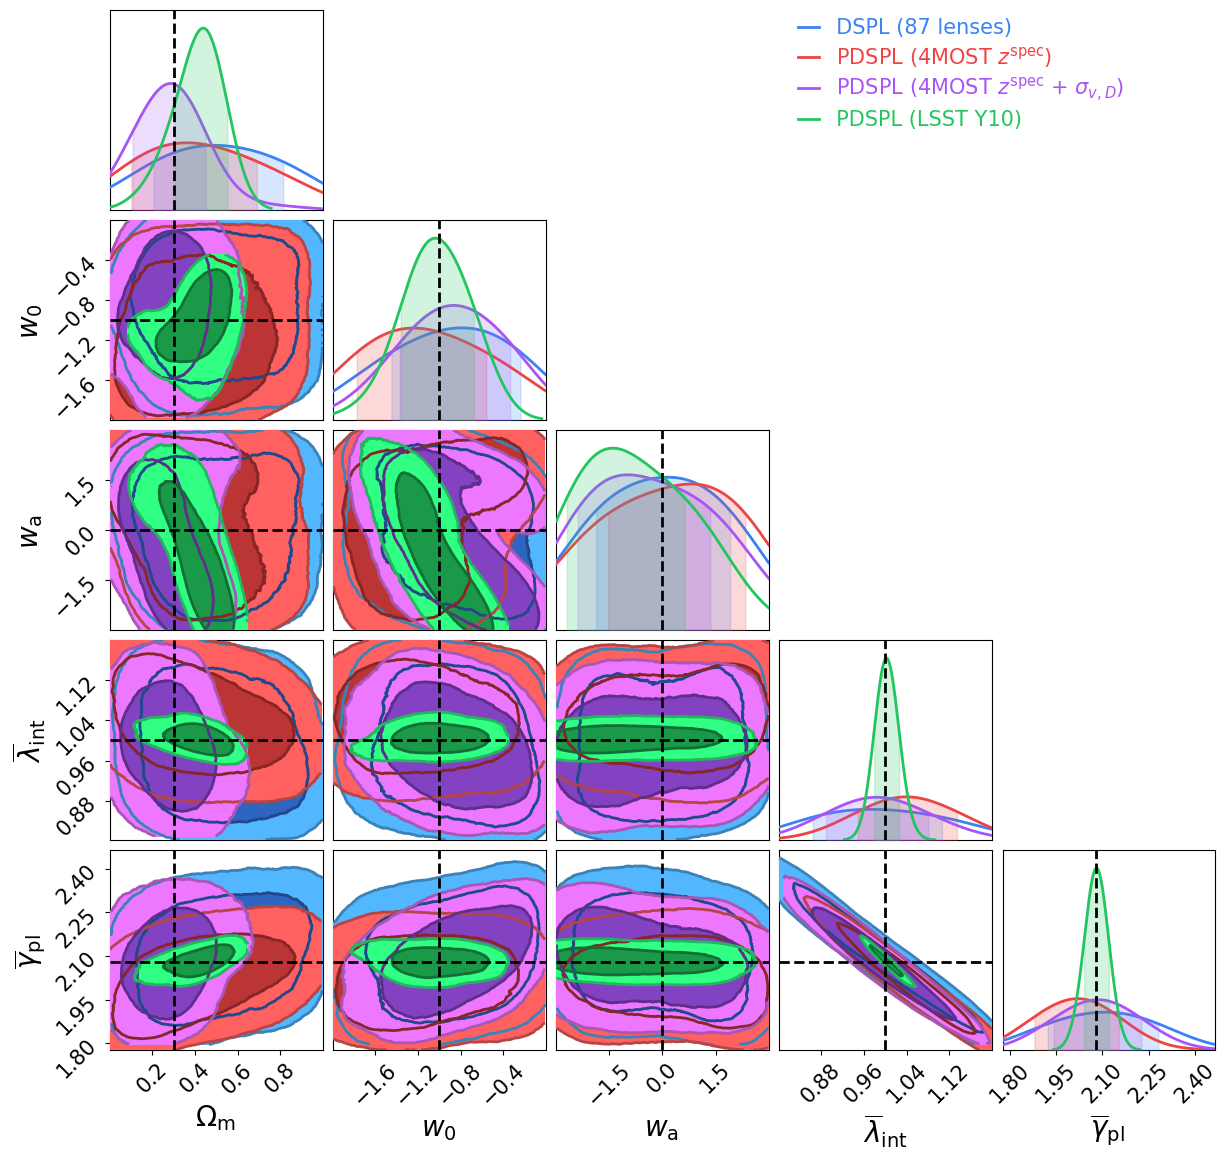

In [64]:
# plot the forecast results using chainconsumer

c = ChainConsumer()

for key in ["DSPL", "lsst_4most_spec-z", "lsst_4most_spec-z_sigma_v", "lsst_y10"]:
    c.add_chain(forecast_samples[key]["chainconsumer_chain"])

c.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": 0.3,
        r"$w_0$": -1,
        r"$w_{\rm a}$": 0,
        r"$\overline{\lambda}_{\rm int}$": 1.0,
        r"$\overline{\gamma}_{\rm pl}$": 2.078,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }, line_width=2)
)

extents = {
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$w_0$": [-2, 0],
                r"$w_{\rm a}$": [-3, 3],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
                # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
            }

c.plotter.set_config(
    PlotConfig(
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
)

c.plotter.plot();

### Prior on $\Omega_{\rm m}$

In [ ]:
# external priors

# sigma_lambda_prior = 0.01
# sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05
# sigma_wa_prior = 0.4

om_true = 0.3
w_true = -1


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    # lambda_int = chain.samples[r"$\overline{\lambda}_{\rm int}$"]
    om = chain.samples[r"$\Omega_{\rm m}$"]
    # gamma_pl = chain.samples[r"$\overline{\gamma}_{\rm pl}$"]
    # wa = chain.samples[r"$w_{\rm a}$"]
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    # weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    # weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    # weights_wa = -(wa - wa_true)**2 / (2*sigma_wa_prior**2)
    # weights = np.exp(weights_gamma + weights_lambda + weights_om + weights_wa)
    weights = np.exp(weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + $\\Omega_{\\rm m}$ prior"
    return chain_weights

## Figures for $w$-CDM cosmology forecast 